<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/LSTM_Model_PyTorch_Dengan_DeteksiSarkasme_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📌 LSTM Model PyTorch Dengan DeteksiSarkasme.json**

# Install Library

In [ ]:
!pip install keras-tuner --quiet


# Import Library

In [ ]:
import json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from tensorflow import keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


# Load Dataset

In [ ]:
# Membaca dataset JSON Lines
data = []
with open('/content/DeteksiSarkasme.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']]
df.head()
display(df)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [ ]:
# Bersihkan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['headline'] = df['headline'].apply(clean_text)

# Tokenisasi
tokenizer = Tokenizer(num_words=30000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['headline'])

sequences = tokenizer.texts_to_sequences(df['headline'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

X = np.array(padded)
y = np.array(df['is_sarcastic'])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Bangun Model

In [ ]:
class SarkasmeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_data = SarkasmeDataset(X_train, y_train)
test_data = SarkasmeDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out).squeeze()


# Latih Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(vocab_size=30000, embedding_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Evaluasi per epoch
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    test_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")


Epoch 1, Train Loss: 0.6872, Test Loss: 0.6858
Epoch 2, Train Loss: 0.6860, Test Loss: 0.6860
Epoch 3, Train Loss: 0.6859, Test Loss: 0.6862
Epoch 4, Train Loss: 0.6859, Test Loss: 0.6860
Epoch 5, Train Loss: 0.6858, Test Loss: 0.6860


# Evaluasi Model

Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      1.00      0.72      2996
         1.0       0.00      0.00      0.00      2346

    accuracy                           0.56      5342
   macro avg       0.28      0.50      0.36      5342
weighted avg       0.31      0.56      0.40      5342

AUC Score: 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


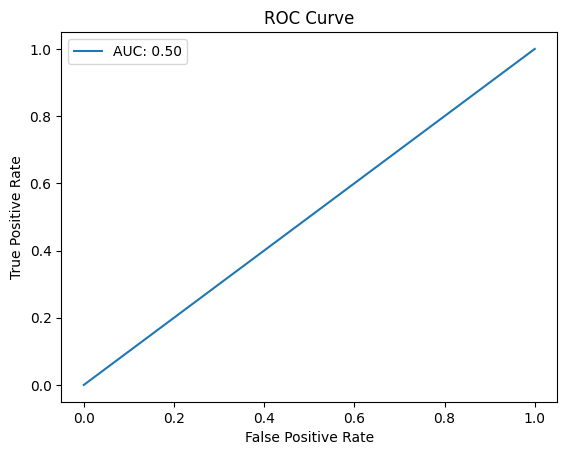

In [ ]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.numpy())

y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

print("Classification Report:\n", classification_report(y_true, y_pred_binary))
print("AUC Score:", roc_auc_score(y_true, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label=f"AUC: {roc_auc_score(y_true, y_pred):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



# Visualisasi

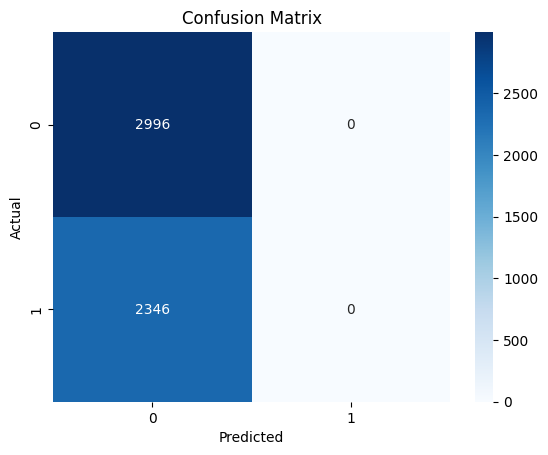

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_true, y_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


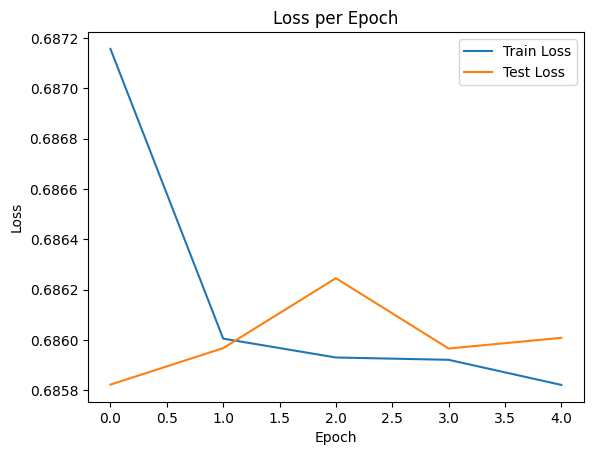

In [ ]:
# Plot Loss
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.show()


# Hyperparameter Tuning with Keras Tuner

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=30000,
                                     output_dim=hp.Choice('embed_dim', [64, 128, 256]),
                                     input_length=100))
    model.add(keras.layers.LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64)))
    model.add(keras.layers.Dropout(rate=hp.Choice('dropout', [0.2, 0.3, 0.5])))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(
                      hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=1,
                        directory='sarcasm_tuning',
                        project_name='lstm_tune')

tuner.search(X_train, y_train, epochs=5, validation_split=0.2, verbose=2)
best_hps = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:", best_hps.values)


Trial 5 Complete [00h 06m 01s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.5538137555122375
Total elapsed time: 00h 59m 06s
Best Hyperparameters: {'embed_dim': 64, 'lstm_units': 128, 'dropout': 0.3, 'learning_rate': 0.0001}
